In [1]:
import itertools
from random import random, randrange, choice
import math

In [2]:
class Ant(object):
    def __init__(self, id_, row, column, memory_size, has_trash):
        self.id_ = id_
        self.row = row
        self.column = column
        self.memory_size = memory_size
        self.has_trash = has_trash
        self.memories = [0] * self.memory_size
        
    def update_position(self, new_row, new_column):
        self.column = new_column
        self.row = new_row
        
    def count_memories(self):
        return self.memories.count(1)
    
    def add_memory(self, value):
        self.memories.pop()
        self.memories.insert(0, value)

In [3]:
def check_possible_moves(row, column, ocean, ant_map, vision_range=1):
    left_row = row
    if -1 < row - vision_range < len(ocean.index):
        left_row = row - vision_range
    
    right_row = row
    if -1 < row + vision_range < len(ocean.index):
        right_row = row + vision_range
    
    left_column = column
    if -1 < column - vision_range < len(ocean.columns):
        left_column = column - vision_range
        
    right_column = column
    if -1 < column + vision_range < len(ocean.columns):
        right_column = column + vision_range
    
    ant_vision = ant_map.loc[left_row:right_row, left_column:right_column]

    moves_row = ant_vision.index.tolist()
    moves_column = ant_vision.columns.tolist()
    
    possible_moves = [[r,c] for r in moves_row for c in moves_column if ant_map.at[r, c] == 0 and [r, c] != [row, column]]
    
    return possible_moves

In [4]:
"""def drop_probability(ant, drop_constant):
    fx = ant.count_memories() / ant.memory_size
    return (fx / drop_constant + fx)**2""";

In [5]:
"""def pick_probability(ant, pick_constant):
    fx = ant.count_memories() / ant.memory_size
    return (pick_constant / pick_constant + fx)**2""";

In [6]:
def calculate_euclidean_distance(from_point, to_point):
    a = to_point[0] - from_point[0]
    b = to_point[1] - from_point[1]

    return math.sqrt((a**2) + (b**2))

In [7]:
def calculate_f(row, column, alpha, ocean, ant_map):
    s = 0
    summation = 0
    
    possible_moves = check_possible_moves(row=row,
                                          column=column,
                                          ocean=ocean,
                                          ant_map=ant_map,
                                          vision_range=1)
    
    for move in possible_moves:
        s += 1
        if ocean.at[move[0], move[1]] == 1:
            distance = calculate_euclidean_distance(from_point=[move[0], move[1]],
                                                    to_point=[row, column])
            summation += (1 - distance/alpha)

    try:
        fi = summation/s
        if fi < 0:
            fi = 0
    except ZeroDivisionError:
        fi = 0
    
    return fi

In [8]:
def move_ants(ocean, ants, ant_map, drop_constant, pick_constant, alpha):
    random_value = random()
    
    for ant in ants:
        possible_moves = check_possible_moves(row=ant.row,
                                              column=ant.column,
                                              ocean=ocean,
                                              ant_map=ant_map,
                                              vision_range=1)
        
        if len(possible_moves) > 0:
            ant_map.at[ant.row, ant.column] = 0
            
            move = choice(possible_moves)

            ant_map.at[move[0], move[1]] = 1
            ant.row = move[0]
            ant.column = move[1]
            
            if ocean.at[move[0], move[1]] == 1 and ant.has_trash == 0:
                fi = calculate_f(row=move[0],
                                 column=move[1],
                                 alpha=alpha,
                                 ocean=ocean,
                                 ant_map=ant_map)
                
                pick_value = (pick_constant / (pick_constant + fi))**2
                
                if random_value < pick_value:
                    ocean.at[move[0], move[1]] = 0
                    ant.has_trash = 1
                
                ant.add_memory(1)
            elif ocean.at[move[0], move[1]] == 1 and ant.has_trash == 1:
                ant.add_memory(1)
            elif ocean.at[move[0], move[1]] == 0 and ant.has_trash == 1:
                fi = calculate_f(row=move[0],
                                 column=move[1],
                                 alpha=alpha,
                                 ocean=ocean,
                                 ant_map=ant_map)
                
                drop_value = 2 * fi if fi < drop_constant else 1
                
                if random_value < drop_value:
                    ocean.at[move[0], move[1]] = 1
                    ant.has_trash = 0
                
                ant.add_memory(0)
            elif ocean.at[move[0], move[1]] == 0 and ant.has_trash == 0:
                ant.add_memory(0)

**DISEÑAR ALGORITMO CON UNA HORMIGA PARA VER SU COMPORTAMIENTO Y EFICIENCIA**

Una hormiga comprobará todas las posiciones visitables del mapa, y si dichas posiciones están o no en su memoria, que en caso de estarlo y no ser un punto de recogida no se visitarán. Pero si por el contrario, la hormiga tiene basura y ha depositado basura en una posición aún en su memoria, retrocederá hasta dicha concentración de basura para soltarla, sino buscará una posible ubicación aleatoria. Sino, por defecto, la hormiga sigue un recorrido aleatorio tenga o no basura y/o información del destino.

In [9]:
import pickle

In [10]:
with open('test_data.pickle', 'rb') as data:
    ocean = pickle.load(data)

In [11]:
total_trash = 0

for _, row in ocean.iterrows():
    for value in row:
        if value == 1:
            total_trash += 1
            
print(f"BASURA INICIAL => {total_trash}")

BASURA INICIAL => 1050


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
plt.figure(figsize=(20,10))
sns.heatmap(ocean, cmap=['#b1dff6', '#804000'], vmin=0, vmax=1)
plt.close()

In [14]:
import pandas as pd

In [15]:
data = [[0 for _ in range(len(ocean.columns))] for _ in range(len(ocean.index))]
ant_map = pd.DataFrame(data)

In [16]:
ants = list()

total_ants = 300
memory_size = 10

In [17]:
for ant in range(1, total_ants + 1):
    flag = False
    
    while flag is False:
        row = randrange(len(ocean.index))
        column = randrange(len(ocean.columns))

        if ant_map.at[row, column] == 1:
            pass

        ants.append(Ant(id_=ant,
                        row=row,
                        column=column,
                        memory_size=memory_size,
                        has_trash=0))

        ant_map.at[row, column] = 1
        flag = True

In [18]:
%%time

total_steps = steps = 100000
drop_constant = .35
pick_constant = .1
alpha = 2.1

while steps > 0:
    move_ants(ocean=ocean,
              ants=ants,
              ant_map=ant_map,
              drop_constant=drop_constant,
              pick_constant=pick_constant,
              alpha=alpha)
    
    print(f"Step Nº{steps}")
    
    """if steps % 1000 == 0:
        plt.figure(figsize=(20,10))
        sns.heatmap(ocean, cmap=['#b1dff6', '#804000'], vmin=0, vmax=1);
        plt.savefig('images/step_' + str(total_steps - steps) + '.png');
        plt.close()"""
    
    steps -= 1

"""plt.figure(figsize=(20,10))
sns.heatmap(ocean, cmap=['#b1dff6', '#804000'], vmin=0, vmax=1);
plt.savefig('images/step_' + str(total_steps - steps) + '.png');
plt.close()"""

Step Nº10000
Step Nº9999
Step Nº9998
Step Nº9997
Step Nº9996
Step Nº9995
Step Nº9994
Step Nº9993
Step Nº9992
Step Nº9991
Step Nº9990
Step Nº9989
Step Nº9988
Step Nº9987
Step Nº9986
Step Nº9985
Step Nº9984
Step Nº9983
Step Nº9982
Step Nº9981
Step Nº9980
Step Nº9979
Step Nº9978
Step Nº9977
Step Nº9976
Step Nº9975
Step Nº9974
Step Nº9973
Step Nº9972
Step Nº9971
Step Nº9970
Step Nº9969
Step Nº9968
Step Nº9967
Step Nº9966
Step Nº9965
Step Nº9964
Step Nº9963
Step Nº9962
Step Nº9961
Step Nº9960
Step Nº9959
Step Nº9958
Step Nº9957
Step Nº9956
Step Nº9955
Step Nº9954
Step Nº9953
Step Nº9952
Step Nº9951
Step Nº9950
Step Nº9949
Step Nº9948
Step Nº9947
Step Nº9946
Step Nº9945
Step Nº9944
Step Nº9943
Step Nº9942
Step Nº9941
Step Nº9940
Step Nº9939
Step Nº9938
Step Nº9937
Step Nº9936
Step Nº9935
Step Nº9934
Step Nº9933
Step Nº9932
Step Nº9931
Step Nº9930
Step Nº9929
Step Nº9928
Step Nº9927
Step Nº9926
Step Nº9925
Step Nº9924
Step Nº9923
Step Nº9922
Step Nº9921
Step Nº9920
Step Nº9919
Step Nº9918
Ste

Step Nº9317
Step Nº9316
Step Nº9315
Step Nº9314
Step Nº9313
Step Nº9312
Step Nº9311
Step Nº9310
Step Nº9309
Step Nº9308
Step Nº9307
Step Nº9306
Step Nº9305
Step Nº9304
Step Nº9303
Step Nº9302
Step Nº9301
Step Nº9300
Step Nº9299
Step Nº9298
Step Nº9297
Step Nº9296
Step Nº9295
Step Nº9294
Step Nº9293
Step Nº9292
Step Nº9291
Step Nº9290
Step Nº9289
Step Nº9288
Step Nº9287
Step Nº9286
Step Nº9285
Step Nº9284
Step Nº9283
Step Nº9282
Step Nº9281
Step Nº9280
Step Nº9279
Step Nº9278
Step Nº9277
Step Nº9276
Step Nº9275
Step Nº9274
Step Nº9273
Step Nº9272
Step Nº9271
Step Nº9270
Step Nº9269
Step Nº9268
Step Nº9267
Step Nº9266
Step Nº9265
Step Nº9264
Step Nº9263
Step Nº9262
Step Nº9261
Step Nº9260
Step Nº9259
Step Nº9258
Step Nº9257
Step Nº9256
Step Nº9255
Step Nº9254
Step Nº9253
Step Nº9252
Step Nº9251
Step Nº9250
Step Nº9249
Step Nº9248
Step Nº9247
Step Nº9246
Step Nº9245
Step Nº9244
Step Nº9243
Step Nº9242
Step Nº9241
Step Nº9240
Step Nº9239
Step Nº9238
Step Nº9237
Step Nº9236
Step Nº9235
Step

Step Nº8634
Step Nº8633
Step Nº8632
Step Nº8631
Step Nº8630
Step Nº8629
Step Nº8628
Step Nº8627
Step Nº8626
Step Nº8625
Step Nº8624
Step Nº8623
Step Nº8622
Step Nº8621
Step Nº8620
Step Nº8619
Step Nº8618
Step Nº8617
Step Nº8616
Step Nº8615
Step Nº8614
Step Nº8613
Step Nº8612
Step Nº8611
Step Nº8610
Step Nº8609
Step Nº8608
Step Nº8607
Step Nº8606
Step Nº8605
Step Nº8604
Step Nº8603
Step Nº8602
Step Nº8601
Step Nº8600
Step Nº8599
Step Nº8598
Step Nº8597
Step Nº8596
Step Nº8595
Step Nº8594
Step Nº8593
Step Nº8592
Step Nº8591
Step Nº8590
Step Nº8589
Step Nº8588
Step Nº8587
Step Nº8586
Step Nº8585
Step Nº8584
Step Nº8583
Step Nº8582
Step Nº8581
Step Nº8580
Step Nº8579
Step Nº8578
Step Nº8577
Step Nº8576
Step Nº8575
Step Nº8574
Step Nº8573
Step Nº8572
Step Nº8571
Step Nº8570
Step Nº8569
Step Nº8568
Step Nº8567
Step Nº8566
Step Nº8565
Step Nº8564
Step Nº8563
Step Nº8562
Step Nº8561
Step Nº8560
Step Nº8559
Step Nº8558
Step Nº8557
Step Nº8556
Step Nº8555
Step Nº8554
Step Nº8553
Step Nº8552
Step

Step Nº7951
Step Nº7950
Step Nº7949
Step Nº7948
Step Nº7947
Step Nº7946
Step Nº7945
Step Nº7944
Step Nº7943
Step Nº7942
Step Nº7941
Step Nº7940
Step Nº7939
Step Nº7938
Step Nº7937
Step Nº7936
Step Nº7935
Step Nº7934
Step Nº7933
Step Nº7932
Step Nº7931
Step Nº7930
Step Nº7929
Step Nº7928
Step Nº7927
Step Nº7926
Step Nº7925
Step Nº7924
Step Nº7923
Step Nº7922
Step Nº7921
Step Nº7920
Step Nº7919
Step Nº7918
Step Nº7917
Step Nº7916
Step Nº7915
Step Nº7914
Step Nº7913
Step Nº7912
Step Nº7911
Step Nº7910
Step Nº7909
Step Nº7908
Step Nº7907
Step Nº7906
Step Nº7905
Step Nº7904
Step Nº7903
Step Nº7902
Step Nº7901
Step Nº7900
Step Nº7899
Step Nº7898
Step Nº7897
Step Nº7896
Step Nº7895
Step Nº7894
Step Nº7893
Step Nº7892
Step Nº7891
Step Nº7890
Step Nº7889
Step Nº7888
Step Nº7887
Step Nº7886
Step Nº7885
Step Nº7884
Step Nº7883
Step Nº7882
Step Nº7881
Step Nº7880
Step Nº7879
Step Nº7878
Step Nº7877
Step Nº7876
Step Nº7875
Step Nº7874
Step Nº7873
Step Nº7872
Step Nº7871
Step Nº7870
Step Nº7869
Step

Step Nº7267
Step Nº7266
Step Nº7265
Step Nº7264
Step Nº7263
Step Nº7262
Step Nº7261
Step Nº7260
Step Nº7259
Step Nº7258
Step Nº7257
Step Nº7256
Step Nº7255
Step Nº7254
Step Nº7253
Step Nº7252
Step Nº7251
Step Nº7250
Step Nº7249
Step Nº7248
Step Nº7247
Step Nº7246
Step Nº7245
Step Nº7244
Step Nº7243
Step Nº7242
Step Nº7241
Step Nº7240
Step Nº7239
Step Nº7238
Step Nº7237
Step Nº7236
Step Nº7235
Step Nº7234
Step Nº7233
Step Nº7232
Step Nº7231
Step Nº7230
Step Nº7229
Step Nº7228
Step Nº7227
Step Nº7226
Step Nº7225
Step Nº7224
Step Nº7223
Step Nº7222
Step Nº7221
Step Nº7220
Step Nº7219
Step Nº7218
Step Nº7217
Step Nº7216
Step Nº7215
Step Nº7214
Step Nº7213
Step Nº7212
Step Nº7211
Step Nº7210
Step Nº7209
Step Nº7208
Step Nº7207
Step Nº7206
Step Nº7205
Step Nº7204
Step Nº7203
Step Nº7202
Step Nº7201
Step Nº7200
Step Nº7199
Step Nº7198
Step Nº7197
Step Nº7196
Step Nº7195
Step Nº7194
Step Nº7193
Step Nº7192
Step Nº7191
Step Nº7190
Step Nº7189
Step Nº7188
Step Nº7187
Step Nº7186
Step Nº7185
Step

Step Nº6583
Step Nº6582
Step Nº6581
Step Nº6580
Step Nº6579
Step Nº6578
Step Nº6577
Step Nº6576
Step Nº6575
Step Nº6574
Step Nº6573
Step Nº6572
Step Nº6571
Step Nº6570
Step Nº6569
Step Nº6568
Step Nº6567
Step Nº6566
Step Nº6565
Step Nº6564
Step Nº6563
Step Nº6562
Step Nº6561
Step Nº6560
Step Nº6559
Step Nº6558
Step Nº6557
Step Nº6556
Step Nº6555
Step Nº6554
Step Nº6553
Step Nº6552
Step Nº6551
Step Nº6550
Step Nº6549
Step Nº6548
Step Nº6547
Step Nº6546
Step Nº6545
Step Nº6544
Step Nº6543
Step Nº6542
Step Nº6541
Step Nº6540
Step Nº6539
Step Nº6538
Step Nº6537
Step Nº6536
Step Nº6535
Step Nº6534
Step Nº6533
Step Nº6532
Step Nº6531
Step Nº6530
Step Nº6529
Step Nº6528
Step Nº6527
Step Nº6526
Step Nº6525
Step Nº6524
Step Nº6523
Step Nº6522
Step Nº6521
Step Nº6520
Step Nº6519
Step Nº6518
Step Nº6517
Step Nº6516
Step Nº6515
Step Nº6514
Step Nº6513
Step Nº6512
Step Nº6511
Step Nº6510
Step Nº6509
Step Nº6508
Step Nº6507
Step Nº6506
Step Nº6505
Step Nº6504
Step Nº6503
Step Nº6502
Step Nº6501
Step

Step Nº5900
Step Nº5899
Step Nº5898
Step Nº5897
Step Nº5896
Step Nº5895
Step Nº5894
Step Nº5893
Step Nº5892
Step Nº5891
Step Nº5890
Step Nº5889
Step Nº5888
Step Nº5887
Step Nº5886
Step Nº5885
Step Nº5884
Step Nº5883
Step Nº5882
Step Nº5881
Step Nº5880
Step Nº5879
Step Nº5878
Step Nº5877
Step Nº5876
Step Nº5875
Step Nº5874
Step Nº5873
Step Nº5872
Step Nº5871
Step Nº5870
Step Nº5869
Step Nº5868
Step Nº5867
Step Nº5866
Step Nº5865
Step Nº5864
Step Nº5863
Step Nº5862
Step Nº5861
Step Nº5860
Step Nº5859
Step Nº5858
Step Nº5857
Step Nº5856
Step Nº5855
Step Nº5854
Step Nº5853
Step Nº5852
Step Nº5851
Step Nº5850
Step Nº5849
Step Nº5848
Step Nº5847
Step Nº5846
Step Nº5845
Step Nº5844
Step Nº5843
Step Nº5842
Step Nº5841
Step Nº5840
Step Nº5839
Step Nº5838
Step Nº5837
Step Nº5836
Step Nº5835
Step Nº5834
Step Nº5833
Step Nº5832
Step Nº5831
Step Nº5830
Step Nº5829
Step Nº5828
Step Nº5827
Step Nº5826
Step Nº5825
Step Nº5824
Step Nº5823
Step Nº5822
Step Nº5821
Step Nº5820
Step Nº5819
Step Nº5818
Step

Step Nº5217
Step Nº5216
Step Nº5215
Step Nº5214
Step Nº5213
Step Nº5212
Step Nº5211
Step Nº5210
Step Nº5209
Step Nº5208
Step Nº5207
Step Nº5206
Step Nº5205
Step Nº5204
Step Nº5203
Step Nº5202
Step Nº5201
Step Nº5200
Step Nº5199
Step Nº5198
Step Nº5197
Step Nº5196
Step Nº5195
Step Nº5194
Step Nº5193
Step Nº5192
Step Nº5191
Step Nº5190
Step Nº5189
Step Nº5188
Step Nº5187
Step Nº5186
Step Nº5185
Step Nº5184
Step Nº5183
Step Nº5182
Step Nº5181
Step Nº5180
Step Nº5179
Step Nº5178
Step Nº5177
Step Nº5176
Step Nº5175
Step Nº5174
Step Nº5173
Step Nº5172
Step Nº5171
Step Nº5170
Step Nº5169
Step Nº5168
Step Nº5167
Step Nº5166
Step Nº5165
Step Nº5164
Step Nº5163
Step Nº5162
Step Nº5161
Step Nº5160
Step Nº5159
Step Nº5158
Step Nº5157
Step Nº5156
Step Nº5155
Step Nº5154
Step Nº5153
Step Nº5152
Step Nº5151
Step Nº5150
Step Nº5149
Step Nº5148
Step Nº5147
Step Nº5146
Step Nº5145
Step Nº5144
Step Nº5143
Step Nº5142
Step Nº5141
Step Nº5140
Step Nº5139
Step Nº5138
Step Nº5137
Step Nº5136
Step Nº5135
Step

Step Nº4534
Step Nº4533
Step Nº4532
Step Nº4531
Step Nº4530
Step Nº4529
Step Nº4528
Step Nº4527
Step Nº4526
Step Nº4525
Step Nº4524
Step Nº4523
Step Nº4522
Step Nº4521
Step Nº4520
Step Nº4519
Step Nº4518
Step Nº4517
Step Nº4516
Step Nº4515
Step Nº4514
Step Nº4513
Step Nº4512
Step Nº4511
Step Nº4510
Step Nº4509
Step Nº4508
Step Nº4507
Step Nº4506
Step Nº4505
Step Nº4504
Step Nº4503
Step Nº4502
Step Nº4501
Step Nº4500
Step Nº4499
Step Nº4498
Step Nº4497
Step Nº4496
Step Nº4495
Step Nº4494
Step Nº4493
Step Nº4492
Step Nº4491
Step Nº4490
Step Nº4489
Step Nº4488
Step Nº4487
Step Nº4486
Step Nº4485
Step Nº4484
Step Nº4483
Step Nº4482
Step Nº4481
Step Nº4480
Step Nº4479
Step Nº4478
Step Nº4477
Step Nº4476
Step Nº4475
Step Nº4474
Step Nº4473
Step Nº4472
Step Nº4471
Step Nº4470
Step Nº4469
Step Nº4468
Step Nº4467
Step Nº4466
Step Nº4465
Step Nº4464
Step Nº4463
Step Nº4462
Step Nº4461
Step Nº4460
Step Nº4459
Step Nº4458
Step Nº4457
Step Nº4456
Step Nº4455
Step Nº4454
Step Nº4453
Step Nº4452
Step

Step Nº3851
Step Nº3850
Step Nº3849
Step Nº3848
Step Nº3847
Step Nº3846
Step Nº3845
Step Nº3844
Step Nº3843
Step Nº3842
Step Nº3841
Step Nº3840
Step Nº3839
Step Nº3838
Step Nº3837
Step Nº3836
Step Nº3835
Step Nº3834
Step Nº3833
Step Nº3832
Step Nº3831
Step Nº3830
Step Nº3829
Step Nº3828
Step Nº3827
Step Nº3826
Step Nº3825
Step Nº3824
Step Nº3823
Step Nº3822
Step Nº3821
Step Nº3820
Step Nº3819
Step Nº3818
Step Nº3817
Step Nº3816
Step Nº3815
Step Nº3814
Step Nº3813
Step Nº3812
Step Nº3811
Step Nº3810
Step Nº3809
Step Nº3808
Step Nº3807
Step Nº3806
Step Nº3805
Step Nº3804
Step Nº3803
Step Nº3802
Step Nº3801
Step Nº3800
Step Nº3799
Step Nº3798
Step Nº3797
Step Nº3796
Step Nº3795
Step Nº3794
Step Nº3793
Step Nº3792
Step Nº3791
Step Nº3790
Step Nº3789
Step Nº3788
Step Nº3787
Step Nº3786
Step Nº3785
Step Nº3784
Step Nº3783
Step Nº3782
Step Nº3781
Step Nº3780
Step Nº3779
Step Nº3778
Step Nº3777
Step Nº3776
Step Nº3775
Step Nº3774
Step Nº3773
Step Nº3772
Step Nº3771
Step Nº3770
Step Nº3769
Step

Step Nº3167
Step Nº3166
Step Nº3165
Step Nº3164
Step Nº3163
Step Nº3162
Step Nº3161
Step Nº3160
Step Nº3159
Step Nº3158
Step Nº3157
Step Nº3156
Step Nº3155
Step Nº3154
Step Nº3153
Step Nº3152
Step Nº3151
Step Nº3150
Step Nº3149
Step Nº3148
Step Nº3147
Step Nº3146
Step Nº3145
Step Nº3144
Step Nº3143
Step Nº3142
Step Nº3141
Step Nº3140
Step Nº3139
Step Nº3138
Step Nº3137
Step Nº3136
Step Nº3135
Step Nº3134
Step Nº3133
Step Nº3132
Step Nº3131
Step Nº3130
Step Nº3129
Step Nº3128
Step Nº3127
Step Nº3126
Step Nº3125
Step Nº3124
Step Nº3123
Step Nº3122
Step Nº3121
Step Nº3120
Step Nº3119
Step Nº3118
Step Nº3117
Step Nº3116
Step Nº3115
Step Nº3114
Step Nº3113
Step Nº3112
Step Nº3111
Step Nº3110
Step Nº3109
Step Nº3108
Step Nº3107
Step Nº3106
Step Nº3105
Step Nº3104
Step Nº3103
Step Nº3102
Step Nº3101
Step Nº3100
Step Nº3099
Step Nº3098
Step Nº3097
Step Nº3096
Step Nº3095
Step Nº3094
Step Nº3093
Step Nº3092
Step Nº3091
Step Nº3090
Step Nº3089
Step Nº3088
Step Nº3087
Step Nº3086
Step Nº3085
Step

Step Nº2484
Step Nº2483
Step Nº2482
Step Nº2481
Step Nº2480
Step Nº2479
Step Nº2478
Step Nº2477
Step Nº2476
Step Nº2475
Step Nº2474
Step Nº2473
Step Nº2472
Step Nº2471
Step Nº2470
Step Nº2469
Step Nº2468
Step Nº2467
Step Nº2466
Step Nº2465
Step Nº2464
Step Nº2463
Step Nº2462
Step Nº2461
Step Nº2460
Step Nº2459
Step Nº2458
Step Nº2457
Step Nº2456
Step Nº2455
Step Nº2454
Step Nº2453
Step Nº2452
Step Nº2451
Step Nº2450
Step Nº2449
Step Nº2448
Step Nº2447
Step Nº2446
Step Nº2445
Step Nº2444
Step Nº2443
Step Nº2442
Step Nº2441
Step Nº2440
Step Nº2439
Step Nº2438
Step Nº2437
Step Nº2436
Step Nº2435
Step Nº2434
Step Nº2433
Step Nº2432
Step Nº2431
Step Nº2430
Step Nº2429
Step Nº2428
Step Nº2427
Step Nº2426
Step Nº2425
Step Nº2424
Step Nº2423
Step Nº2422
Step Nº2421
Step Nº2420
Step Nº2419
Step Nº2418
Step Nº2417
Step Nº2416
Step Nº2415
Step Nº2414
Step Nº2413
Step Nº2412
Step Nº2411
Step Nº2410
Step Nº2409
Step Nº2408
Step Nº2407
Step Nº2406
Step Nº2405
Step Nº2404
Step Nº2403
Step Nº2402
Step

Step Nº1801
Step Nº1800
Step Nº1799
Step Nº1798
Step Nº1797
Step Nº1796
Step Nº1795
Step Nº1794
Step Nº1793
Step Nº1792
Step Nº1791
Step Nº1790
Step Nº1789
Step Nº1788
Step Nº1787
Step Nº1786
Step Nº1785
Step Nº1784
Step Nº1783
Step Nº1782
Step Nº1781
Step Nº1780
Step Nº1779
Step Nº1778
Step Nº1777
Step Nº1776
Step Nº1775
Step Nº1774
Step Nº1773
Step Nº1772
Step Nº1771
Step Nº1770
Step Nº1769
Step Nº1768
Step Nº1767
Step Nº1766
Step Nº1765
Step Nº1764
Step Nº1763
Step Nº1762
Step Nº1761
Step Nº1760
Step Nº1759
Step Nº1758
Step Nº1757
Step Nº1756
Step Nº1755
Step Nº1754
Step Nº1753
Step Nº1752
Step Nº1751
Step Nº1750
Step Nº1749
Step Nº1748
Step Nº1747
Step Nº1746
Step Nº1745
Step Nº1744
Step Nº1743
Step Nº1742
Step Nº1741
Step Nº1740
Step Nº1739
Step Nº1738
Step Nº1737
Step Nº1736
Step Nº1735
Step Nº1734
Step Nº1733
Step Nº1732
Step Nº1731
Step Nº1730
Step Nº1729
Step Nº1728
Step Nº1727
Step Nº1726
Step Nº1725
Step Nº1724
Step Nº1723
Step Nº1722
Step Nº1721
Step Nº1720
Step Nº1719
Step

Step Nº1116
Step Nº1115
Step Nº1114
Step Nº1113
Step Nº1112
Step Nº1111
Step Nº1110
Step Nº1109
Step Nº1108
Step Nº1107
Step Nº1106
Step Nº1105
Step Nº1104
Step Nº1103
Step Nº1102
Step Nº1101
Step Nº1100
Step Nº1099
Step Nº1098
Step Nº1097
Step Nº1096
Step Nº1095
Step Nº1094
Step Nº1093
Step Nº1092
Step Nº1091
Step Nº1090
Step Nº1089
Step Nº1088
Step Nº1087
Step Nº1086
Step Nº1085
Step Nº1084
Step Nº1083
Step Nº1082
Step Nº1081
Step Nº1080
Step Nº1079
Step Nº1078
Step Nº1077
Step Nº1076
Step Nº1075
Step Nº1074
Step Nº1073
Step Nº1072
Step Nº1071
Step Nº1070
Step Nº1069
Step Nº1068
Step Nº1067
Step Nº1066
Step Nº1065
Step Nº1064
Step Nº1063
Step Nº1062
Step Nº1061
Step Nº1060
Step Nº1059
Step Nº1058
Step Nº1057
Step Nº1056
Step Nº1055
Step Nº1054
Step Nº1053
Step Nº1052
Step Nº1051
Step Nº1050
Step Nº1049
Step Nº1048
Step Nº1047
Step Nº1046
Step Nº1045
Step Nº1044
Step Nº1043
Step Nº1042
Step Nº1041
Step Nº1040
Step Nº1039
Step Nº1038
Step Nº1037
Step Nº1036
Step Nº1035
Step Nº1034
Step

Step Nº379
Step Nº378
Step Nº377
Step Nº376
Step Nº375
Step Nº374
Step Nº373
Step Nº372
Step Nº371
Step Nº370
Step Nº369
Step Nº368
Step Nº367
Step Nº366
Step Nº365
Step Nº364
Step Nº363
Step Nº362
Step Nº361
Step Nº360
Step Nº359
Step Nº358
Step Nº357
Step Nº356
Step Nº355
Step Nº354
Step Nº353
Step Nº352
Step Nº351
Step Nº350
Step Nº349
Step Nº348
Step Nº347
Step Nº346
Step Nº345
Step Nº344
Step Nº343
Step Nº342
Step Nº341
Step Nº340
Step Nº339
Step Nº338
Step Nº337
Step Nº336
Step Nº335
Step Nº334
Step Nº333
Step Nº332
Step Nº331
Step Nº330
Step Nº329
Step Nº328
Step Nº327
Step Nº326
Step Nº325
Step Nº324
Step Nº323
Step Nº322
Step Nº321
Step Nº320
Step Nº319
Step Nº318
Step Nº317
Step Nº316
Step Nº315
Step Nº314
Step Nº313
Step Nº312
Step Nº311
Step Nº310
Step Nº309
Step Nº308
Step Nº307
Step Nº306
Step Nº305
Step Nº304
Step Nº303
Step Nº302
Step Nº301
Step Nº300
Step Nº299
Step Nº298
Step Nº297
Step Nº296
Step Nº295
Step Nº294
Step Nº293
Step Nº292
Step Nº291
Step Nº290
Step Nº289

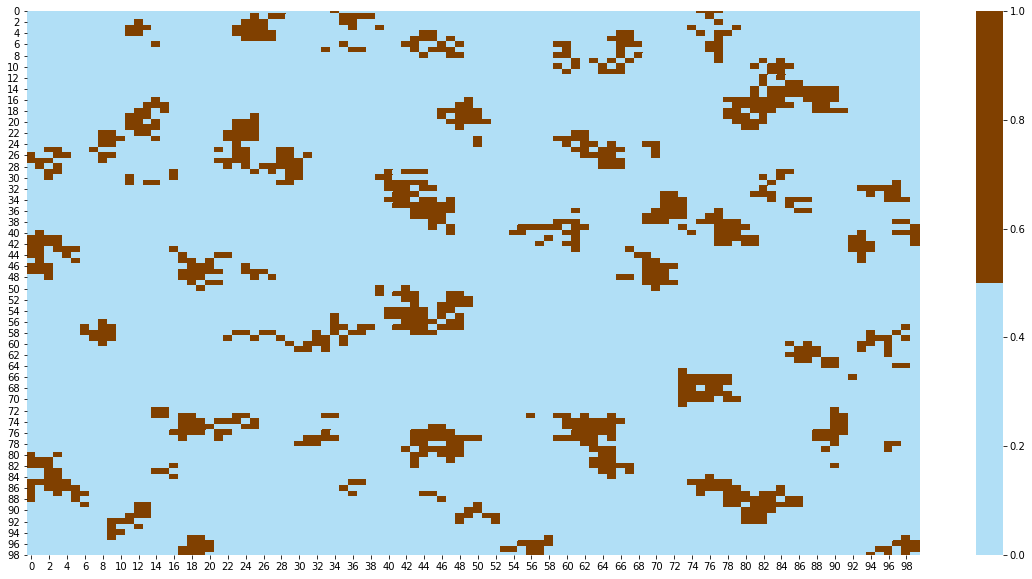

In [19]:
plt.figure(figsize=(20,10))
sns.heatmap(ocean, cmap=['#b1dff6', '#804000'], vmin=0, vmax=1)

In [20]:
trash_count = 0

for _, row in ocean.iterrows():
    for value in row:
        if value == 1:
            trash_count += 1
            
print(f"BASURA FINAL => {trash_count}")

BASURA FINAL => 992


In [21]:
for ant in ants:
    if ant.has_trash == 1:
        print(f"HORMIGA {ant.id_} CON BASURA!")

HORMIGA 9 CON BASURA!
HORMIGA 22 CON BASURA!
HORMIGA 24 CON BASURA!
HORMIGA 34 CON BASURA!
HORMIGA 35 CON BASURA!
HORMIGA 37 CON BASURA!
HORMIGA 41 CON BASURA!
HORMIGA 51 CON BASURA!
HORMIGA 56 CON BASURA!
HORMIGA 61 CON BASURA!
HORMIGA 63 CON BASURA!
HORMIGA 64 CON BASURA!
HORMIGA 66 CON BASURA!
HORMIGA 68 CON BASURA!
HORMIGA 73 CON BASURA!
HORMIGA 76 CON BASURA!
HORMIGA 88 CON BASURA!
HORMIGA 94 CON BASURA!
HORMIGA 104 CON BASURA!
HORMIGA 112 CON BASURA!
HORMIGA 122 CON BASURA!
HORMIGA 125 CON BASURA!
HORMIGA 128 CON BASURA!
HORMIGA 129 CON BASURA!
HORMIGA 136 CON BASURA!
HORMIGA 138 CON BASURA!
HORMIGA 145 CON BASURA!
HORMIGA 146 CON BASURA!
HORMIGA 172 CON BASURA!
HORMIGA 174 CON BASURA!
HORMIGA 186 CON BASURA!
HORMIGA 192 CON BASURA!
HORMIGA 209 CON BASURA!
HORMIGA 219 CON BASURA!
HORMIGA 220 CON BASURA!
HORMIGA 222 CON BASURA!
HORMIGA 223 CON BASURA!
HORMIGA 224 CON BASURA!
HORMIGA 225 CON BASURA!
HORMIGA 228 CON BASURA!
HORMIGA 233 CON BASURA!
HORMIGA 239 CON BASURA!
HORMIGA 240

In [22]:
ants_with_trash = 0

for ant in ants:
    if ant.has_trash == 1:
        ants_with_trash += 1
        
print(f"HORMIGAS CON BASURA AL FINAL => {ants_with_trash}")

HORMIGAS CON BASURA AL FINAL => 58
